### Testing Neural Network based Anomaly Detection on simulated data

#### This code generates large dataframe containing multiple timeseries, randomly adds changes in both mean and variance (anomalies), tries to train neural network to distinguish measurements belonging to the timebin under investigation from measurements in a reference time period.

In [2]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from pandas.tseries.offsets import *

Using TensorFlow backend.


#### parameters to set

In [3]:
# fix random seed for reproducibility
np.random.seed(17)

# parameters of simulated data generation
n_series = 5
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-07 23:59:59'

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 2 * 10E-6
max_anomaly_duration = 4*3600 # 4 h


# lenghts of subject and reference time periods
refh = 12
subh = 1

# probability to correctly classify sample based purely on luck
chance = refh/(subh+refh)
# how much better than luck we want to be to say we detected an anomaly. Default is 5%
cut = chance + (1-chance) * 0.05

print('chance:',chance, '\tcut:', cut)
ref = refh * Hour()
sub = subh * Hour()

# number of training epochs 
epochs=60

chance: 0.9230769230769231 	cut: 0.926923076923077


#### generate normal data

In [4]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(10, 80), n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df['score']=0.5
df.index = dti
#df.head()

#### generate anomalies

In [5]:
def random_anomalies():
    to_generate = int(n_timesteps * p_anomaly)
    for a in range(to_generate):
        affects = random.sample(range(n_series), random.randint(1, n_series))
        duration = int(max_anomaly_duration * random.random())
        start = int(n_timesteps * random.random())
        end = min(start+duration, n_timesteps)
        print('affected:', affects, df.iloc[start].name, df.iloc[end].name)
        for s in affects:
            df.iloc[start:end,s] = df.iloc[start:end,s] + random.random() * 0.2
        df.iloc[start:end,n_series]=1
        
random_anomalies()

affected: [1, 3, 2] 2017-08-07 07:03:06 2017-08-07 10:18:11
affected: [3, 0] 2017-08-01 02:31:55 2017-08-01 03:36:01
affected: [1, 0] 2017-08-02 05:53:05 2017-08-02 06:36:01
affected: [0, 3, 2, 4] 2017-08-05 23:22:07 2017-08-06 01:13:34
affected: [4, 1, 3, 0] 2017-08-03 13:35:14 2017-08-03 15:41:20
affected: [4, 3] 2017-08-06 07:58:49 2017-08-06 08:32:29
affected: [3, 2, 0] 2017-08-02 00:10:01 2017-08-02 03:18:34
affected: [1, 0, 2] 2017-08-01 14:09:06 2017-08-01 17:50:53
affected: [3, 1, 4, 0] 2017-08-02 19:05:22 2017-08-02 22:46:54
affected: [1, 4, 2] 2017-08-06 08:41:37 2017-08-06 10:35:28
affected: [4] 2017-08-06 19:39:15 2017-08-06 19:47:25
affected: [1, 0, 2, 3] 2017-08-03 12:21:47 2017-08-03 14:05:08


#### enforce range

In [6]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

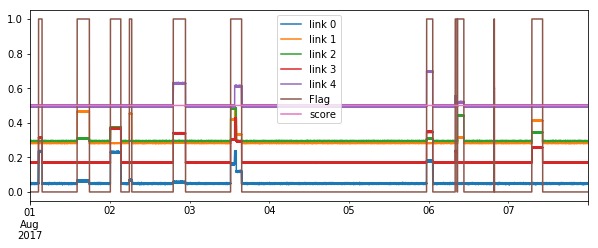

In [7]:
df.plot(figsize=(10,3.5))

#### create NN

In [8]:
def getModel():
    model = Sequential()
    model.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#         model.add(Dropout(0.5))
    model.add(Dense(units=n_series*2, activation='relu'))    
#         model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid') )
    
    model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#         model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### functions

In [9]:
def check_for_anomaly(ref, sub, count):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['Flag']
    del X_ref['score']
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['Flag']
    del X_sub['score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    X_train_s, y_train_s = shuffle(X_train, y_train)
    
    m=getModel()
    hist = m.fit(X_train_s.values, y_train_s.values, epochs=epochs, verbose=0, shuffle=True, batch_size=256)

    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    #print(loss_and_metrics)

    if loss_and_metrics[1] > cut:# or not count%5: 
        plotHist(hist)
        
    return loss_and_metrics[1]

#### Looping over time intervals

0
13184/14040 [===========================>..] - ETA: 0s
 2017-08-01 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 26.604431867599487
1
13856/14040 [============================>.] - ETA: 0s
 2017-08-01 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 22.938879251480103
2
12672/14040 [==========================>...] - ETA: 0s

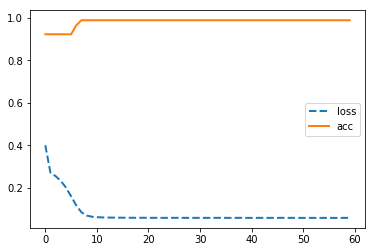


 2017-08-01 15:00:00 	refes: 43200 	subjects: 3600 	score: 0.986538461606
took: 23.590627431869507
3


KeyboardInterrupt: 

In [10]:
#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0


# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    print(count)
    startt = time()
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    score = check_for_anomaly(ref_df, sub_df, count)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['score']] = score
    print('\n',ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tscore:', score)
    ti = ti + sub
    count=count+1
    endt=time()
    print("took:", endt-startt)
#     if count>2: break
    


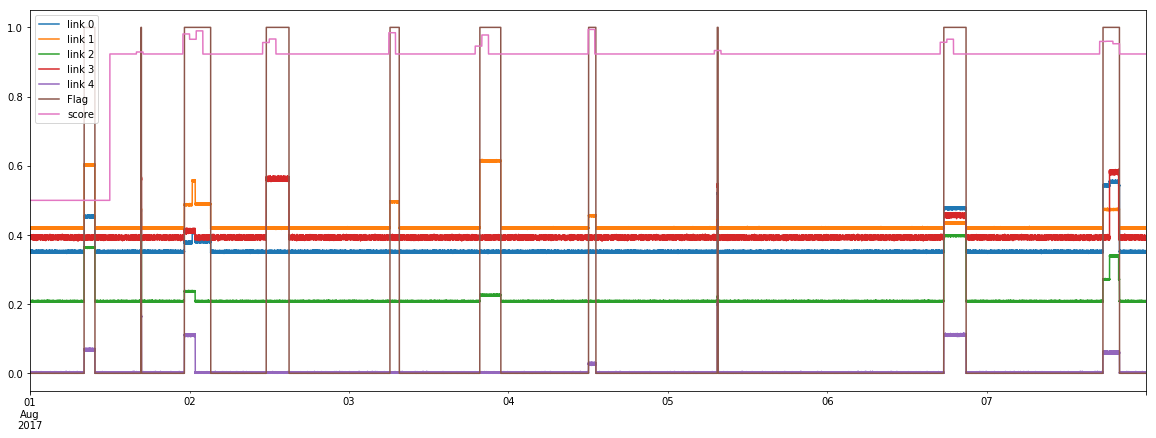

In [11]:
df.plot(figsize=(20,7))


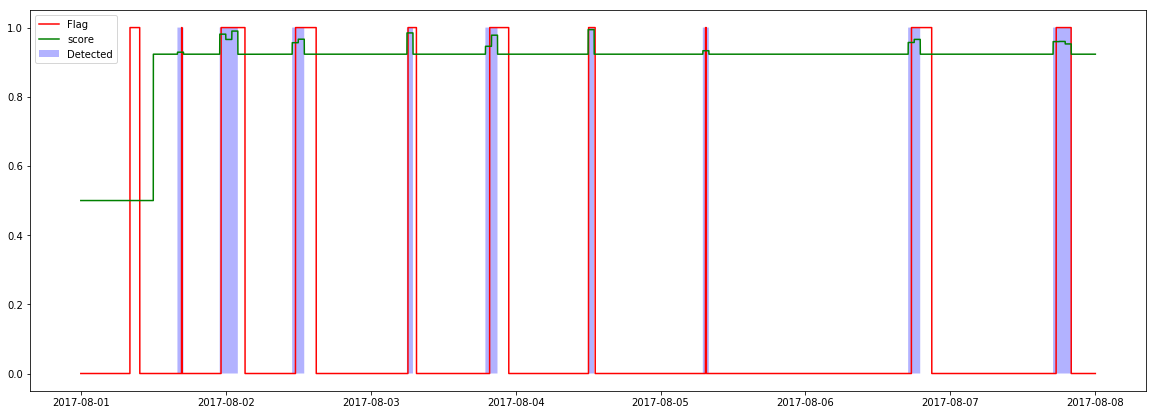

In [12]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.score>cut,'Detected']=1
df.head()
ax.plot(df.Flag, 'r')
ax.plot(df.score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()